In [1]:
import pandas as pd
import numpy as np

In [2]:
pathogenicity = pd.read_csv('pathogenicity_scores.csv')

In [3]:
pathogenicity.head(5)

,Patient_ID,Mutation_ID,LABEL,SCORE_A,SCORE_B,SCORE_C
0,1,1,0,0.291,0.005307,0.298077
1,1,2,1,0.504,0.024089,0.920095
2,1,3,0,0.361,0.010909,0.327322
3,1,4,0,0.020,0.002804,0.618246
4,1,5,0,0.035,0.000870,0.279782


In [4]:
print( len(pathogenicity.Patient_ID.drop_duplicates()) )# 107명 환자번호 확인 
print( pathogenicity.LABEL.drop_duplicates().values) # class 개수 확인
print('\n')
print(np.min(pathogenicity.loc[:,['SCORE_A','SCORE_B','SCORE_C']])) # SCORE의 최대 최소를 확인해서 [0,1] 범위에 모든 데이터가 사이에 다 들어가는지 확인
print('\n')
print(np.max(pathogenicity.loc[:,['SCORE_A','SCORE_B','SCORE_C']]))

107
[0 1]


SCORE_A    0.000000e+00
SCORE_B    1.975366e-07
SCORE_C    1.162547e-01
dtype: float64


SCORE_A    0.995000
SCORE_B    0.999234
SCORE_C    0.975275
dtype: float64


In [5]:
# binary cross entropy
from sklearn.metrics import log_loss

true_all = pathogenicity.LABEL.values

for col_name in ['SCORE_A','SCORE_B','SCORE_C']:
    predict_all = pathogenicity[col_name].values

    BCE = log_loss(true_all, predict_all)
    print('%s BCE: %0.3f'%(col_name, BCE))

SCORE_A BCE: 0.333
SCORE_B BCE: 0.502
SCORE_C BCE: 0.783


optimal_threshold : [0.504, 0.7859845757484436, 0.7425392866130001]


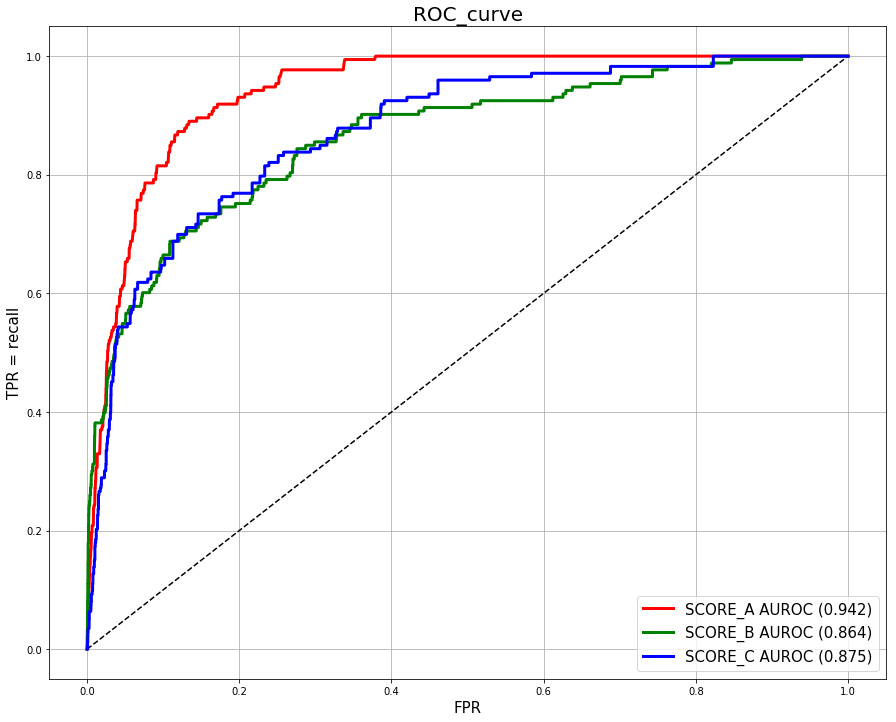

In [10]:
# AUROC 비교 
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

lw = 3
plt.figure(figsize=(15,12))
plt.plot([0, 1], [0, 1], color='k', linestyle='--')

true_all = pathogenicity.LABEL.values

colors=pd.DataFrame({'SCORE_A':['r'],'SCORE_B':['g'],'SCORE_C':['b']})

optimal_threshold=[]
for col_name in ['SCORE_A','SCORE_B','SCORE_C']:
    predict_all = pathogenicity[col_name].values

    score = roc_auc_score(true_all, predict_all)
    fpr, tpr, thresholds = roc_curve(true_all, predict_all)
    
    plt.plot(fpr, tpr, lw=lw, color=colors[col_name].values[0], label= '%s AUROC (%0.3f)' % (col_name,score))
    
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold.append(thresholds[optimal_idx])



print('optimal_threshold :', optimal_threshold)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR = recall', fontsize=15)
plt.grid()
plt.title('ROC_curve', fontsize=20)
plt.legend(loc="lower right", prop={'size': 15})
#plt.savefig('./roc_'+test_name+'.png', dpi=300)

In [7]:
print('1의 개수 :', sum(pathogenicity.LABEL),'\n','총 개수 : ', len(pathogenicity))

# LABEL의 1이 매우 적어서 class가 unbalance하므로 f1 score나 AUPRC를 측정해 볼 필요가 있음.

1의 개수 : 173 
 총 개수 :  29473


In [8]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

true_all = pathogenicity.LABEL.values

for col_name in ['SCORE_A','SCORE_B','SCORE_C']:
    predict_all = pathogenicity[col_name].values

    average_precision = average_precision_score(true_all, predict_all)
    print('%s Average precision-recall score : %0.3f'%(col_name, average_precision))



SCORE_A Average precision-recall score : 0.115
SCORE_B Average precision-recall score : 0.151
SCORE_C Average precision-recall score : 0.058


In [9]:
#f1 score , threshold = ROC에서 구한 각각의 optimal_threshold
import numpy as np

def score_f1(y_true, y_pred,threshold): #taken from old keras source code
    epsil=0.001
    true_positives = np.sum(np.where((y_true * y_pred)>threshold,1,0))
    possible_positives = np.sum(y_true)
    predicted_positives = np.sum(np.where(y_pred>threshold,1,0))
    precision = true_positives / (predicted_positives + epsil)
    recall = true_positives / (possible_positives + epsil)
    f1_val = 2*(precision*recall)/(precision+recall+epsil)
    return f1_val


true_all = pathogenicity.LABEL.values

for col_name, threshold in zip(['SCORE_A','SCORE_B','SCORE_C'],optimal_threshold):
    predict_all = pathogenicity[col_name].values

    f1score = score_f1(true_all, predict_all,threshold)
    print('%s f1 score : %0.3f'%(col_name, f1score))


SCORE_A f1 score : 0.072
SCORE_B f1 score : 0.068
SCORE_C f1 score : 0.055
